# [HOMEWORK 3 - Interactive Visualization](https://nbviewer.jupyter.org/github/mathmout/ada/blob/master/03%20-%20Interactive%20Viz/Homework3-2.ipynb?flush_cache=true)

To see our notebook with the maps please click [here](https://nbviewer.jupyter.org/github/mathmout/ada/blob/master/03%20-%20Interactive%20Viz/Homework3-2.ipynb?flush_cache=true)

In [28]:
import folium
import pandas as pd
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import csv
import re

%matplotlib inline 

### 1) Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

Source : http://ec.europa.eu/eurostat/web/products-datasets/-/tsdec450<br>
Total unemployment rate from 1990 to 2016 in EU


In [2]:
header = pd.read_excel('data/unemployment_rate_eurostat.xls',sheetname='Sheet0', header = 3).columns
header.values[0] = "Country"

In [3]:
# Load data from xls spreadsheet to pandas dataframe 
eurostat_unemployment_rate = pd.read_excel('data/unemployment_rate_eurostat.xls', sheetname='Sheet0',
                                           skiprows=4, skip_footer=9, header = None)
eurostat_unemployment_rate.columns = header

# Replace :=not available  values and p=provisional  values by NaN
eurostat_unemployment_rate = eurostat_unemployment_rate.replace(":", "NaN")
eurostat_unemployment_rate = eurostat_unemployment_rate.replace("(p)", "NaN")
 

# Drop columns that contain no values
eurostat_unemployment_rate = eurostat_unemployment_rate.dropna( axis=1)




Load the data of Switzerland for the year 2016 and add them to the data frame `eurostat_unemployment_rate`

In [4]:
Swiss_rate2016 = pd.read_excel('data/swiss2016.xlsx', sheetname='swiss2016')
Swiss_rate2016=(Swiss_rate2016.loc[Swiss_rate2016['Mesures']=='Taux de chômage']['Resultats'].values[0]).astype(float)
swiss_index=eurostat_unemployment_rate[eurostat_unemployment_rate['Country']=='Switzerland'].index

eurostat_unemployment_rate.set_value(swiss_index,'2016',Swiss_rate2016)

eurostat_unemployment_rate['2016'] = eurostat_unemployment_rate['2016'].astype(float)

In [5]:
#drop country that are not in Europe
eurostat_unemployment_rate=eurostat_unemployment_rate.drop(eurostat_unemployment_rate[eurostat_unemployment_rate['Country']=='United States'].index);
eurostat_unemployment_rate=eurostat_unemployment_rate.drop(eurostat_unemployment_rate[eurostat_unemployment_rate['Country']=='Japan'].index);


In [6]:
eurostat_unemployment_rate[['Country','2016']].tail()

,Country,2016
31,United Kingdom,4.8
32,Iceland,3.0
33,Norway,4.7
34,Switzerland,3.3
35,Turkey,10.9


   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.
   
- We choose to not display the countries in Europe for whose we didn't have any values.
- As scale we used a linear color ramp, in order to not distord the data, and show changes of color at regular intervals. Otherwise the color difference for small variations could be the same as the color difference for big variation in the unemployment rate. 


In [7]:
# We save the countries name
countries = eurostat_unemployment_rate["Country"]

topojson_path = 'topojson/europe.topojson.json'
topojson =  open( topojson_path, encoding='utf-8' )
topojson_data = json.load( topojson )

# We delete the countries with no data in the topojson
for i,element in reversed(list(enumerate(topojson_data["objects"]['europe']["geometries"]))):
    if element["properties"]["NAME"] not in list(countries):
        del topojson_data["objects"]['europe']["geometries"][i]

In [8]:

m_eu = folium.Map(location=(54,15), zoom_start=3.6)

m_eu.choropleth(geo_data=topojson_data, topojson='objects.europe',
    data=eurostat_unemployment_rate, columns=['Country','2016'],
    key_on="feature.properties.NAME",
    fill_color='YlOrRd', fill_opacity= 0.7, line_opacity=0.7,line_color='white',
    legend_name='Unemployment rate'
)

m_eu

(if you don't see the map click map please click [here](https://nbviewer.jupyter.org/github/mathmout/ada/blob/master/03%20-%20Interactive%20Viz/Homework3-2.ipynb?flush_cache=true))

On the choropleth map, one can see that compared to that of the rest of Europe, Switzerland's unemployment rate is one of the lowest.

To be more precise the following plot shows the 8 countries in Europe with the lowest unemployment rate for the year 2016. Switzerland is second with an employement rate of 3.3%


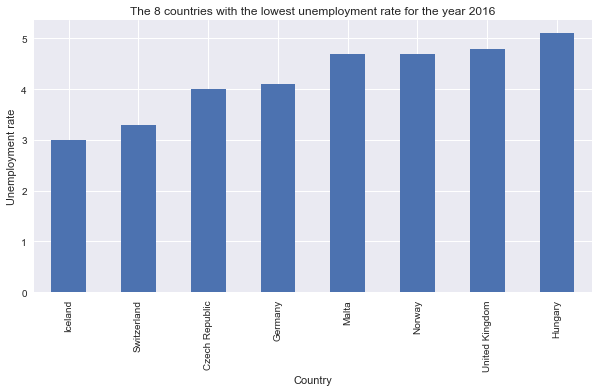

In [9]:
def plot_barh_chart (df, x, y, title, ylabel, xlabel) :
    
    df = df.sort_values(y, ascending=[1])
    ax = df[:8]\
                      .plot(y=y,
                            x=x,
                            kind='bar',
                            figsize=(10, 5))
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend_.remove()
    ax.set_title(title)



    
plot_barh_chart( eurostat_unemployment_rate , 'Country', '2016', 
                'The 8 countries with the lowest unemployment rate for the year 2016', 
                'Unemployment rate', 'Country' )

### 2) Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

In [10]:
#Load the data of Switzerland
swiss_data = pd.read_excel(r'data/Taux_de_chomage.xlsx',sheetname='2.1 Taux de chômage')

In [11]:
#We create a Dictionary to obtain the Canton ID:
Canton_ID = {"Zurich":'ZH', "Berne":'BE', "Lucerne":'LU','Uri':'UR','Schwyz':'SZ',
           'Obwald':'OW','Nidwald':'NW','Glaris':'GL','Zoug':'ZG',
           'Fribourg':'FR','Soleure':'SO','Bâle-Ville':'BS',
            'Bâle-Campagne':'BL','Schaffhouse':'SH',
           'Appenzell Rhodes-Intérieures':'AI','Appenzell Rhodes-Extérieures':'AR',
           'St-Gall':'SG','Grisons':'GR','Argovie':'AG','Thurgovie':'TG',
           'Tessin':'TI','Vaud':'VD','Valais':'VS','Neuchâtel':'NE',
           'Genève':'GE','Jura':'JU','Total':'Total'}

swiss_data['Canton ID']=swiss_data['Canton'].map(Canton_ID)
swiss_data[['Canton','Canton ID','Taux de chômage']].head()

,Canton,Canton ID,Taux de chômage
0,Zurich,ZH,3.3
1,Berne,BE,2.4
2,Lucerne,LU,1.7
3,Uri,UR,0.6
4,Schwyz,SZ,1.7


 Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.


- On the website we check the definition of the unemployement rate:
https://www.amstat.ch/v2/definition.jsp?lang=fr
The Swiss Confederation defines the unemployement as the number of unemployement peopledivided by the size of the active population (scaled by 100). And not as the number of people looking for a job divided by the size of the active population (scaled by 100).

In [12]:
topojson_path = 'topojson/ch-cantons.topojson.json'
topojson =  open( topojson_path, encoding='utf-8' )
topojson_data = json.load( topojson )

#### Unemployment rate
See the map here : [Unemployment rate](Unemployment_rate.html)

In [13]:
#Delete row Total
swiss_data = swiss_data.loc[swiss_data.Canton != "Total"]

swiss_data['Taux de chômage'] = swiss_data['Taux de chômage'].astype(float)

#Function to display the swiss map accorrding to one column
def displaySwissMap(data,col,title):

    m = folium.Map(location=[46.8, 8.33], zoom_start=7.5)
    m.choropleth(geo_data=topojson_data, topojson='objects.cantons',
        data=data, columns=['Canton ID',col],
        key_on="feature.id",
        fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.7,line_color='white',
        legend_name=title
    )

    return m

displaySwissMap(swiss_data,
                'Taux de chômage',
                'Unemployment rate')

We can see on this map that the unemployment rate of the cantons of Neuchatel and Geneva is quite high in comparison to the rest of Switzerland. The East part of Switzerland has the lower rate of unemployement.
#### People looking for a job rate

In [14]:
population_totale = swiss_data["Chômeurs inscrits"]/swiss_data["Taux de chômage"]
swiss_data["People looking for a job rate"] = swiss_data["Demandeurs d'emploi"]/population_totale


displaySwissMap(swiss_data,
                'People looking for a job rate',
                'People looking for a job rate')

This map is a little  differente. Indeed the people looking for a job rate is more important in the West part of the country. Only the center of the country (around Zurich) has a low rate of people looking for a job.


NB: The colorscale is different on this map because we think what is important to see is the difference between inside the country.
#### Non unemployed people looking for a job rate

In [15]:
swiss_data["Non unemployed people looking for a job rate"] = swiss_data["Demandeurs d'emploi non chômeurs"]/population_totale

displaySwissMap(swiss_data,
                "Non unemployed people looking for a job rate",
                "Non unemployed looking for a job rate")

This map is quite interesting because we can this some importants difference with the previous maps. Indeed Geneva is not a canton with a high rate of non unemployed people looking for a job. Conversely the Grison has a bad rate on this map while they have a low unemployement rate. We could assume that in the Grison more people are unhappy with their job. 

The center of the country (around Zurich) has a low rate of people looking for a job.

### 3) Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

To show the difference in unemployment rates between the foreign and the Swiss workers, we plotted directly the difference: $r_{foreign}-r_{swiss}$

Like this we don't have to show two separate maps. 

In [16]:
# Load data from xls spreadsheet to pandas dataframe 
nationalite_amstat = pd.read_excel('data/nationalite_amstat.xlsx', sheetname='2.1 Taux de chômage')
nationalite_amstat['Canton ID']=nationalite_amstat['Canton'].map(Canton_ID)


In [17]:
foreign_swiss=pd.pivot_table(nationalite_amstat,['Taux de chômage'],['Canton','Canton ID'],'Nationalité')
foreign_swiss=foreign_swiss.reset_index()
foreign_swiss['difference unemployement F-S']=foreign_swiss['Taux de chômage']['Etrangers']-foreign_swiss['Taux de chômage']['Suisses']
foreign_swiss.head()

Canton Canton ID Taux de chômage          \
Nationalité                                               Etrangers Suisses   
0            Appenzell Rhodes-Extérieures        AR             3.4     1.4   
1            Appenzell Rhodes-Intérieures        AI             2.0     0.5   
2                                 Argovie        AG             5.6     2.1   
3                                   Berne        BE             5.5     1.8   
4                           Bâle-Campagne        BL             4.8     2.2   

            difference unemployement F-S  
Nationalité                               
0                                    2.0  
1                                    1.5  
2                                    3.5  
3                                    3.7  
4                                    2.6

In [18]:
displaySwissMap(foreign_swiss,
                'difference unemployement F-S',
                'Unemployment rate difference')

In [19]:
# Load data from xls spreadsheet to pandas dataframe 
classe_age = pd.read_excel('data/classe_age.xls',sheetname='classe_age.csv',skifooter=2)


classe_age['Canton ID']=classe_age['Canton'].map(Canton_ID)

#ENGLISH TRANSLATION:

english_dict = {'15-24 ans':'15-24 years','25-49 ans':'25-49 years','50 ans et plus':'50 years and more'}

classe_age["Classes d'âge "]=classe_age["Classes d'âge "].map(english_dict)

classe_age = classe_age.rename(index=str, columns={
                                "Classes d'âge ": "Age groups",
                                "Taux de chômage": "Unemployment rate"
                               })  

classe_age = classe_age.sort_values('Unemployment rate', ascending=[0])

classe_age= classe_age[['Canton ID','Canton','Age groups','Unemployment rate']]

In the following plot we see for the different Cantons, the difference of the unemployment rate depending on the age groups. The unemployment rate for the age groups *15-24 years* is almost always the highest.

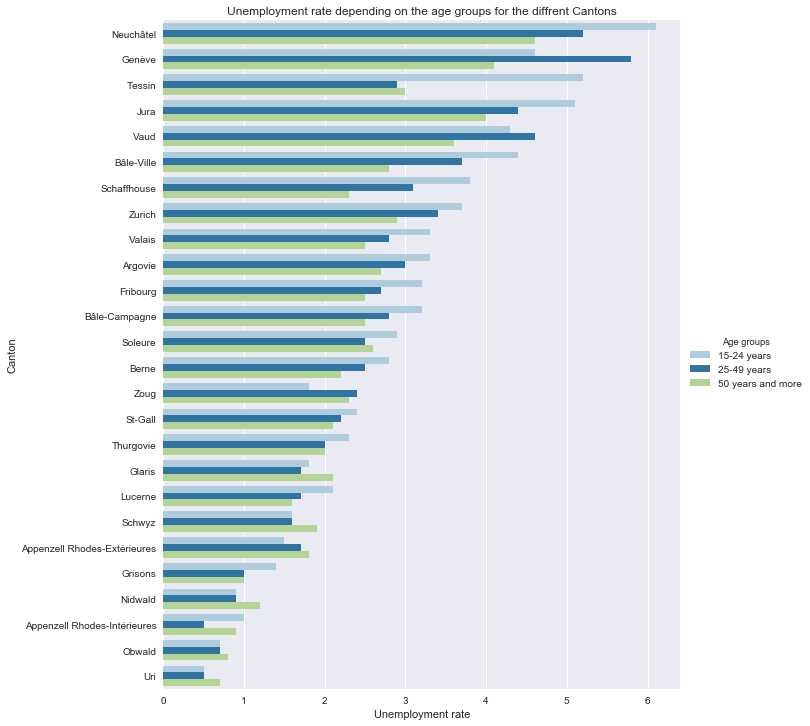

In [20]:
sns.factorplot( x="Unemployment rate",y="Canton",hue='Age groups',kind='bar',size=10, data=classe_age,palette="Paired")
plt.title('Unemployment rate depending on the age groups for the diffrent Cantons')

Knowing the number of unemployed Swiss and foreign for each age category can obtain the proportion. So said that for example in Zürich for the age groups *15-24 years* the 3.7% of unemploymement correspond to 2.6% of Young *Swiss*, and 1.1% of Young *Foreign*. 


Be carefull here $1.1\%=\frac{NU_{young-foreign}}{NA_{young}}$ and not equal to $\frac{NU_{young-foreign}}{NA_{young-foreign}}$. 

With:

-$NU_{young-foreign}$: The number of *Young Unemployed Foreign*

-$NA_{young-foreign}$: The number of *Young Active Foreign*

-$NA_{young}$: The number of *Young Active* so the sum of *Young Active Swiss* and *Young Active Foreign*

In [21]:
# Load data of the number of swiss and foreign by age category
age_nationalite = pd.read_excel('data/age_nationalite.xlsx',sheetname='Sheet1')

In [22]:
age_nationalite.head()

,Mois,Canton,Classes d'âge,age,Nationalité,Chômeurs inscrits
0,2017-09-01,Zurich,1,15-24 ans,Etrangers,1'015
1,2017-09-01,Zurich,1,15-24 ans,Suisses,2'405
2,2017-09-01,Zurich,1,15-24 ans,Total,3'420
3,2017-09-01,Zurich,2,25-49 ans,Etrangers,8'846
4,2017-09-01,Zurich,2,25-49 ans,Suisses,8'207


In [23]:
def string_to_int(x):
    x=re.sub('[^0-9]','', str(x))
    return int(x)

In [24]:
#Convert the values of 'Chômeurs inscrits' in a int
age_nationalite['Chômeurs inscrits'] = age_nationalite['Chômeurs inscrits'].apply(lambda x : string_to_int(x))

In [25]:
# Add thos information to the dataframe classe_age and recompute the rat for both foreign and Swiss
classe_age = classe_age.sort_values(['Canton','Age groups'], ascending=[1,1])
age_nationalite = age_nationalite.sort_values(['Canton','age'], ascending=[1,1])

classe_age['number of foreigners']=age_nationalite.loc[age_nationalite['Nationalité']=='Etrangers']['Chômeurs inscrits'].values
classe_age['number of Swiss']=age_nationalite.loc[age_nationalite['Nationalité']=='Suisses']['Chômeurs inscrits'].values
classe_age['unemployment rate of foreigners']=classe_age['Unemployment rate']*classe_age['number of foreigners']/(classe_age['number of foreigners']+classe_age['number of Swiss'])
classe_age['unemployment rate of Swiss']=classe_age['Unemployment rate']*classe_age['number of Swiss']/(classe_age['number of foreigners']+classe_age['number of Swiss'])

In [26]:
classe_age.tail(6)

,Canton ID,Canton,Age groups,Unemployment rate,number of foreigners,number of Swiss,unemployment rate of foreigners,unemployment rate of Swiss
24,ZG,Zoug,15-24 years,1.8,41,92,0.554887,1.245113
25,ZG,Zoug,25-49 years,2.4,497,438,1.275722,1.124278
26,ZG,Zoug,50 years and more,2.3,179,296,0.866737,1.433263
0,ZH,Zurich,15-24 years,3.7,1015,2405,1.098099,2.601901
1,ZH,Zurich,25-49 years,3.4,8846,8207,1.763701,1.636299
2,ZH,Zurich,50 years and more,2.9,2250,4502,0.966380,1.933620


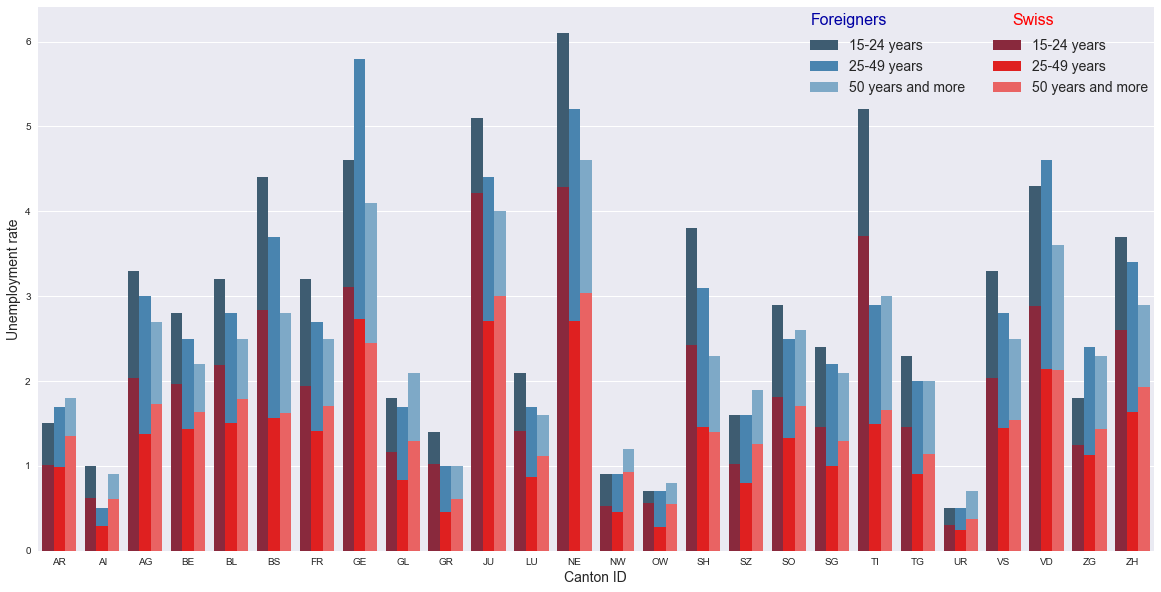

In [27]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

#Plot 1 - background - "total" (top) series
a = sns.factorplot(x = 'Canton ID',
                   y = 'Unemployment rate',
                   palette="Blues_d",
                   hue='Age groups',
                   kind='bar',
                   data=classe_age,
                   ax=ax)

#Plot 2 - overlay - "bottom" series
b = sns.factorplot(x = 'Canton ID',
                   y = 'unemployment rate of Swiss',
                   palette = [[0.6,0.1,0.2],'#FF0000',[1,0.3,0.3]],
                   hue='Age groups',
                   kind='bar',
                   data=classe_age,
                   ax=ax)

plt.close(a.fig)
plt.close(b.fig)
plt.legend(bbox_to_anchor=(0., 0.85, 1., .102),
           loc=1,
           ncol=2,
           borderaxespad=0.,
           fontsize=14)
plt.text(22.2, 6.2, r'Swiss', fontsize=16, color='red')
plt.text(17.5, 6.2, r'Foreigners', fontsize=16, color='#0000A3')
plt.xlabel('Canton ID', fontsize=14)
plt.ylabel('Unemployment rate', fontsize=14)

One can see, on the previous graph that for the age groups 25-49 years, the unemployment rate is almost the same for foreign and swiss. Considering the others category, the unemployment rate is lower for foreign. This coulds be explained by the fact that for this age category the total number of swiss, and foreign is more balanced. And for the others the total number of Swiss is really higher than the number of foreign.